# 3D Graphics Systems | AI Graphics - Theory and Practice | IMPA 2023
### Instructor: Luiz Velho
### TA: Hallison Paz
### Course info: https://lvelho.impa.br/i3d23/

## Lab Class #4 - Bundle Adjustment

# Absolute camera orientation given set of relative camera pairs

The problem we deal with is defined as follows:

Given an optical system of $N$ cameras with extrinsics $\{g_1, ..., g_N | g_i \in SE(3)\}$, and a set of relative camera positions $\{g_{ij} | g_{ij}\in SE(3)\}$ that map between coordinate frames of randomly selected pairs of cameras $(i, j)$, we search for the absolute extrinsic parameters $\{g_1, ..., g_N\}$ that are consistent with the relative camera motions.

More formally:
$$
g_1, ..., g_N =
{\arg \min}_{g_1, ..., g_N} \sum_{g_{ij}} d(g_{ij}, g_i^{-1} g_j),
$$,
where $d(g_i, g_j)$ is a suitable metric that compares the extrinsics of cameras $g_i$ and $g_j$.

Visually, the problem can be described as follows. The picture below depicts the situation at the beginning of our optimization. The ground truth cameras are plotted in purple while the randomly initialized estimated cameras are plotted in orange:


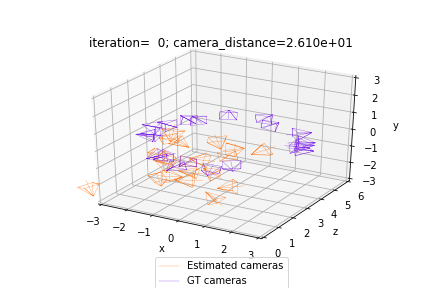

Our optimization seeks to align the estimated (orange) cameras with the ground truth (purple) cameras, by minimizing the discrepancies between pairs of relative cameras. Thus, the solution to the problem should look as follows:

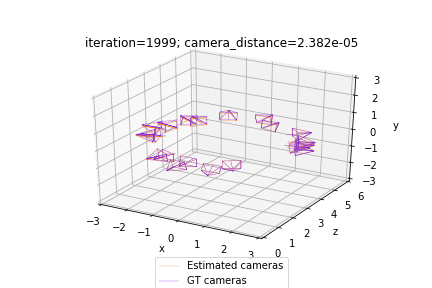

In practice, the camera extrinsics $g_{ij}$ and $g_i$ are represented using objects from the `PerspectiveCameras` class initialized with the corresponding rotation and translation matrices `R_absolute` and `T_absolute` that define the extrinsic parameters $g = (R, T); R \in SO(3); T \in \mathbb{R}^3$. In order to ensure that `R_absolute` is a valid rotation matrix, we represent it using an exponential map (implemented with `so3_exponential_map`) of the axis-angle representation of the rotation `log_R_absolute`.

## 0. Install and Import Modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("2.1.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=ca9f94a8a4919bf73901568af15e0dc51365353d91ebee03742afc1726c9e719
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=6ead971732f0140d4ff90aa028c5bccc436cda8e75b9d41f41a48ffe7728dab3
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 194.9 MB/s eta 0:00:00


In [2]:
# imports
import matplotlib.pyplot as plt
import torch
from pytorch3d.transforms.so3 import (
    so3_exponential_map,
    so3_relative_angle,
)
from pytorch3d.renderer.cameras import (
    PerspectiveCameras,
)

from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    RasterizationSettings, PointLights, MeshRenderer,
    MeshRasterizer, SoftPhongShader
)

# add path for demo utils
import sys
import os
sys.path.append(os.path.abspath(''))

# set for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

If using **Google Colab**, fetch the utils file for plotting the camera scene, and the ground truth camera positions:

In [3]:
!wget https://raw.githubusercontent.com/hallpaz/3dsystems23/master/scripts/camera_visualization.py
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from camera_visualization import plot_camera_scene
from plot_image_grid import image_grid

!mkdir data
!wget -P data https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/data/camera_graph.pth

--2023-11-23 21:21:18--  https://raw.githubusercontent.com/hallpaz/3dsystems23/master/scripts/camera_visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2178 (2.1K) [text/plain]
Saving to: ‘camera_visualization.py’

camera_visualizatio 100%[===================>]   2.13K  --.-KB/s    in 0s      

2023-11-23 21:21:19 (21.4 MB/s) - ‘camera_visualization.py’ saved [2178/2178]

--2023-11-23 21:21:19--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, aw

OR if running **locally** uncomment and run the following cell:

In [ ]:
# from utils import plot_camera_scene
# from utils import image_grid

## 1. Set up Cameras and load ground truth positions

In [4]:
# load the SE3 graph of relative/absolute camera positions
camera_graph_file = './data/camera_graph.pth'
(R_absolute_gt, T_absolute_gt), \
    (R_relative, T_relative), \
    relative_edges = \
        torch.load(camera_graph_file)

# create the relative cameras
cameras_relative = PerspectiveCameras(
    R = R_relative.to(device),
    T = T_relative.to(device),
    device = device,
)

# create the absolute ground truth cameras
cameras_absolute_gt = PerspectiveCameras(
    R = R_absolute_gt.to(device),
    T = T_absolute_gt.to(device),
    device = device,
)

# the number of absolute camera positions
N = R_absolute_gt.shape[0]

1.1 Check the ground truth values for rotation and translation of the first camera $g_0$. Do they look like measured values or arbitrary ones? Why do you think this decision was taken?

In [ ]:
##############################################################################
# Code and explanation for 1.1
##############################################################################

In [5]:
# GT rotation for g0
R_absolute_gt[0]

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [6]:
# GT translation form g0
T_absolute_gt[0]

tensor([-0., -0., -0.])

## 2. Define optimization functions

### Relative cameras and camera distance
We now define two functions crucial for the optimization.

**`calc_camera_distance`** compares a pair of cameras. This function is important as it defines the loss that we are minimizing. The method utilizes the `so3_relative_angle` function from the SO3 API.

**`get_relative_camera`** computes the parameters of a relative camera that maps between a pair of absolute cameras. Here we utilize the `compose` and `inverse` class methods from the PyTorch3D Transforms API.

In [7]:
def calc_camera_distance(cam_1, cam_2):
    """
    Calculates the divergence of a batch of pairs of cameras cam_1, cam_2.
    The distance is composed of the cosine of the relative angle between
    the rotation components of the camera extrinsics and the L2 distance
    between the translation vectors.
    """
    # rotation distance
    R_distance = (1.-so3_relative_angle(cam_1.R, cam_2.R, cos_angle=True)).mean()
    # translation distance
    T_distance = ((cam_1.T - cam_2.T)**2).sum(1).mean()
    # the final distance is the sum
    return R_distance + T_distance

def get_relative_camera(cams, edges):
    """
    For each pair of indices (i,j) in "edges" generate a camera
    that maps from the coordinates of the camera cams[i] to
    the coordinates of the camera cams[j]
    """

    # first generate the world-to-view Transform3d objects of each
    # camera pair (i, j) according to the edges argument
    trans_i, trans_j = [
        PerspectiveCameras(
            R = cams.R[edges[:, i]],
            T = cams.T[edges[:, i]],
            device = device,
        ).get_world_to_view_transform()
         for i in (0, 1)
    ]

    # compose the relative transformation as g_i^{-1} g_j
    trans_rel = trans_i.inverse().compose(trans_j)

    # generate a camera from the relative transform
    matrix_rel = trans_rel.get_matrix()
    cams_relative = PerspectiveCameras(
                        R = matrix_rel[:, :3, :3],
                        T = matrix_rel[:, 3, :3],
                        device = device,
                    )
    return cams_relative

2.1 In this task, we are parameterizing the 3D rotation group - $SO(3)$ - using rotation matrices. This choice has some drawbacks, as we need to ensure our matrices are valid rotation matrices. Which other choice(s) could we have used to parameterize rotations? Would it be a better choice?

In [ ]:
##############################################################################
# Explanation for 2.1
##############################################################################

* PyTorch3D transforms code https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/transforms/so3.html
* Rodrigues Rotation formula: https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula
* Other representations of a rotation https://rotations.berkeley.edu/other-representations-of-a-rotation/
* Euler Angles and Gimbal Lock: http://webserver2.tecgraf.puc-rio.br/~mgattass/demo/EulerAnglesRotations-GimballLock/euler.html

## 3. Optimization
Finally, we start the optimization of the absolute cameras.

We use SGD with momentum and optimize over `log_R_absolute` and `T_absolute`.

As mentioned earlier, `log_R_absolute` is the axis angle representation of the rotation part of our absolute cameras. We can obtain the 3x3 rotation matrix `R_absolute` that corresponds to `log_R_absolute` with:

`R_absolute = so3_exponential_map(log_R_absolute)`


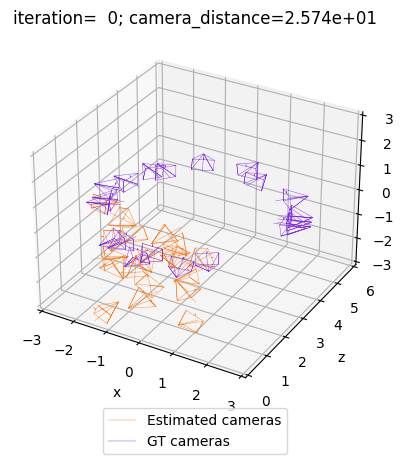

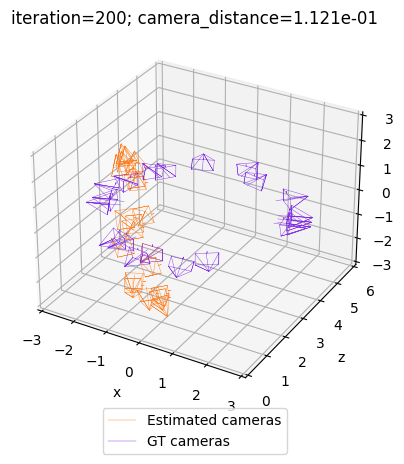

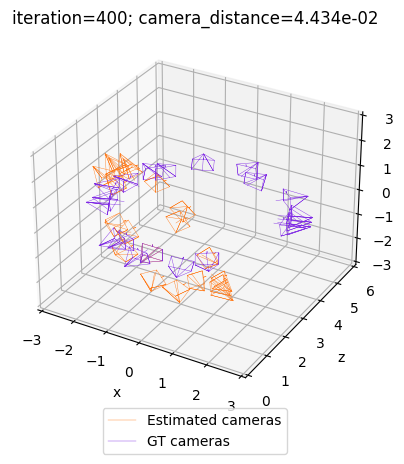

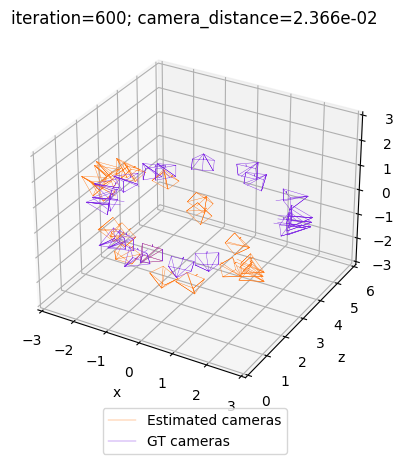

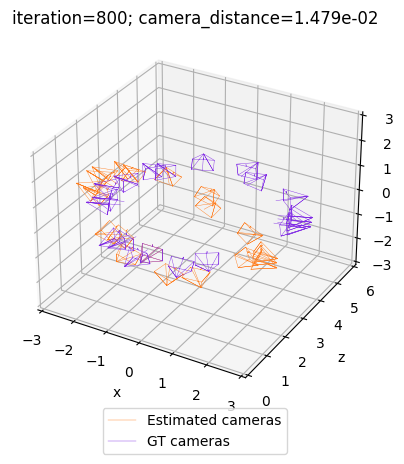

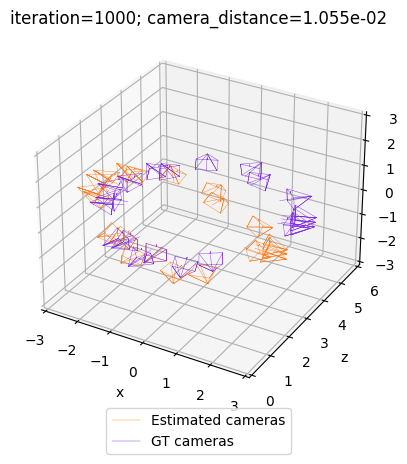

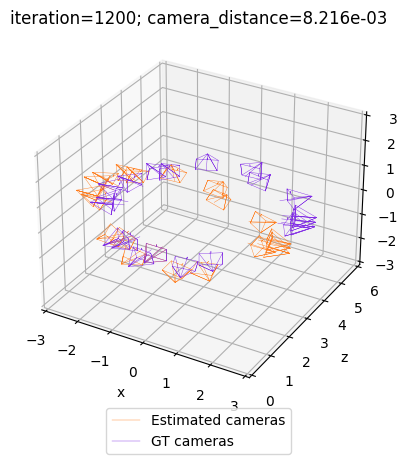

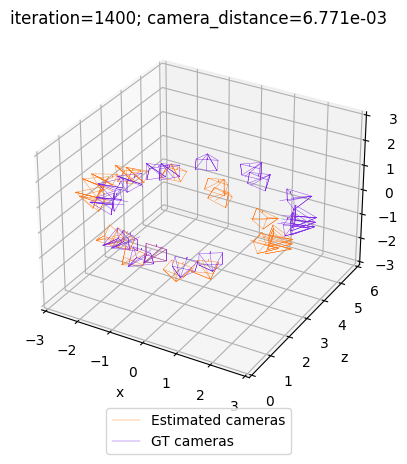

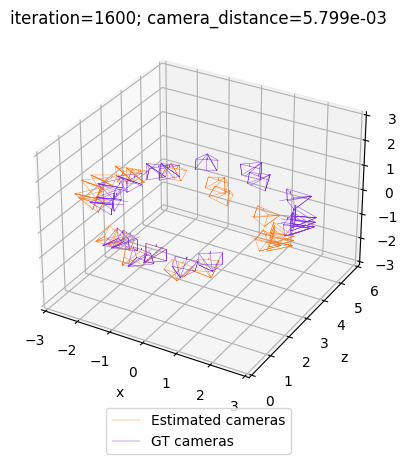

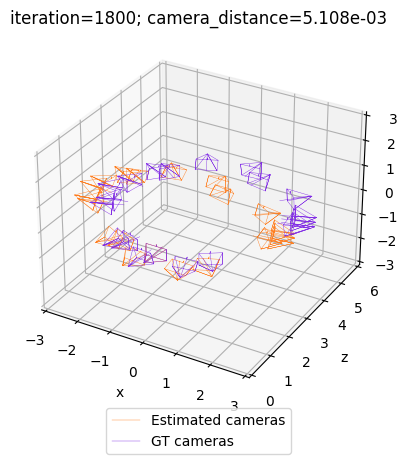

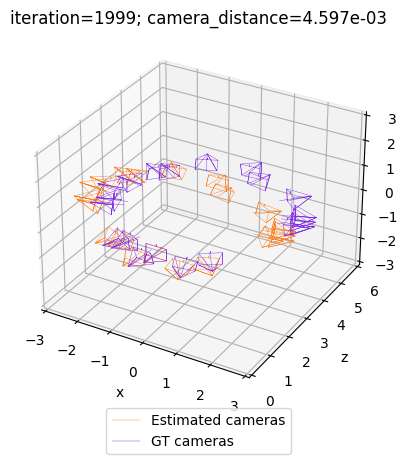

Optimization finished.


In [8]:
# initialize the absolute log-rotations/translations with random entries
log_R_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)
T_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)

# furthermore, we know that the first camera is a trivial one
# (check exercise 1.1 above)
log_R_absolute_init[0, :] = 0.
T_absolute_init[0, :] = 0.

# instantiate a copy of the initialization of log_R / T
log_R_absolute = log_R_absolute_init.clone().detach()
log_R_absolute.requires_grad = True
T_absolute = T_absolute_init.clone().detach()
T_absolute.requires_grad = True

# the mask the specifies which cameras are going to be optimized
#     (since we know the first camera is already correct,
#      we only optimize over the 2nd-to-last cameras)
camera_mask = torch.ones(N, 1, dtype=torch.float32, device=device)
camera_mask[0] = 0.

# init the optimizer
optimizer = torch.optim.SGD([log_R_absolute, T_absolute], lr=.1, momentum=0.9)

losses = []
# run the optimization
n_iter = 2000  # fix the number of iterations
for it in range(n_iter):
    # re-init the optimizer gradients
    optimizer.zero_grad()

    # compute the absolute camera rotations as
    # an exponential map of the logarithms (=axis-angles)
    # of the absolute rotations
    R_absolute = so3_exponential_map(log_R_absolute * camera_mask)

    # get the current absolute cameras
    cameras_absolute = PerspectiveCameras(
        R = R_absolute,
        T = T_absolute * camera_mask,
        device = device,
    )

    # compute the relative cameras as a compositon of the absolute cameras
    cameras_relative_composed = \
        get_relative_camera(cameras_absolute, relative_edges)

    # compare the composed cameras with the ground truth relative cameras
    # camera_distance corresponds to $d$ from the description
    camera_distance = \
        calc_camera_distance(cameras_relative_composed, cameras_relative)

    # 3.2 SAVE LOSS VALUE TO PLOT LATER
    losses.append(camera_distance.item())

    # our loss function is the camera_distance
    camera_distance.backward()

    # apply the gradients
    optimizer.step()

    # plot and print status message
    if it % 200==0 or it==n_iter-1:
        status = 'iteration=%3d; camera_distance=%1.3e' % (it, camera_distance)
        plot_camera_scene(cameras_absolute, cameras_absolute_gt, status)

print('Optimization finished.')


3.1. Download the *cow mesh* and user the function `render_scene` (below) to render it using the cameras of the ground truth. Do the same using the initial values of the estimated cameras.

*You don't need to understand how to set up a renderer now, we'll cover this later on the couser. For now, just focus on analyzing the results.*

In [9]:
# download the cow mesh
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2023-11-23 21:22:27--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.14, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  --.-KB/s    in 0.04s   

2023-11-23 21:22:27 (9.00 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2023-11-23 21:22:27--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.14, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[=========

In [10]:
def render_scene(meshes, cameras, device):
  """
  Renders 3D meshes to a tensor of images.

  Args:
    meshes: a Meshes instance holding the meshes to be rendered
    cameras: a pytorch3D Cameras instance such as PerspectiveCameras
    device: a torch.device

  """
  if len(meshes) != len(cameras):
    meshes = meshes.extend(len(cameras))

  raster_settings = RasterizationSettings(
      image_size=512,
      blur_radius=0.0,
      faces_per_pixel=1,
  )
  lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
  renderer = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=cameras,
          raster_settings=raster_settings
      ),
      shader=SoftPhongShader(
          device=device,
          cameras=cameras,
          lights=lights
      )
  )
  return renderer(meshes).detach()

# you can visualize the images using the image_grid function:
# images = renderer(meshes, cameras, device)
# image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

# or you can choose a single image to check with matplotlib
# plt.figure(figsize=(10, 10))
# plt.imshow(images[0, ..., :3].cpu().numpy())
# plt.grid("off");
# plt.axis("off");

In [ ]:
##############################################################################
# Code for 3.1
##############################################################################

In [11]:
cow_mesh = load_objs_as_meshes(["/content/data/cow_mesh/cow.obj"], device=device)

In [12]:
gtimages = render_scene(cow_mesh, cameras_absolute_gt, device)

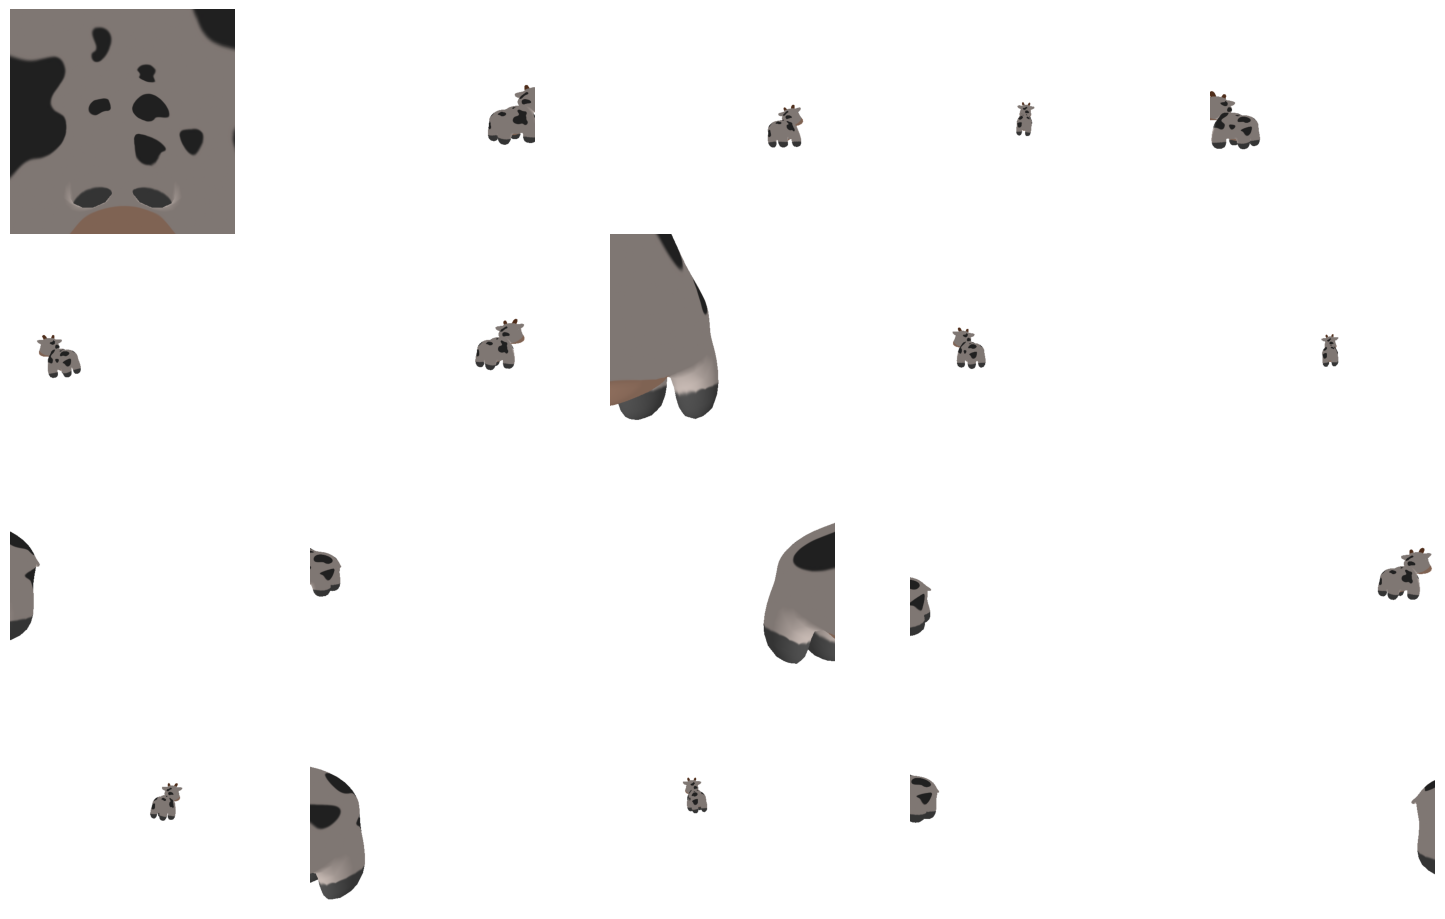

In [13]:
image_grid(gtimages.cpu().numpy(), rows=4, cols=5, rgb=True)

In [14]:
# initialize the absolute log-rotations/translations with random entries
log_R_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)
T_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)
log_R_absolute_init[0, :] = 0.
T_absolute_init[0, :] = 0.

# instantiate a copy of the initialization of log_R / T
log_R_absolute = log_R_absolute_init.clone().detach()
T_absolute = T_absolute_init.clone().detach()

# get rotation matrices
R_absolute = so3_exponential_map(log_R_absolute)

# get the current absolute cameras
cameras_absolute = PerspectiveCameras(
    R = R_absolute,
    T = T_absolute,
    device = device,
)

In [15]:
rdm_images = render_scene(cow_mesh, cameras_absolute, device)

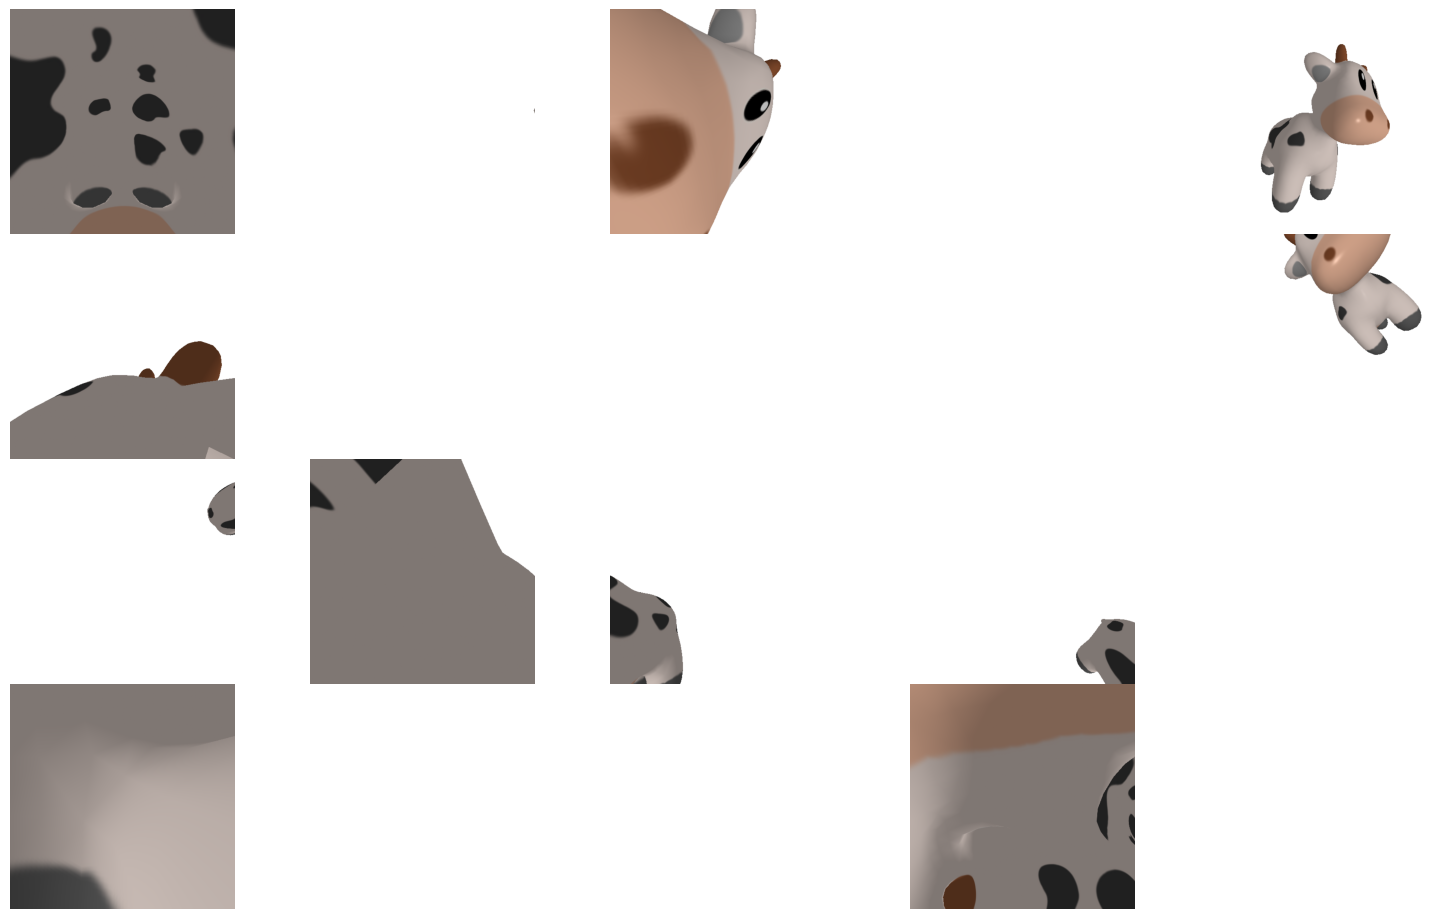

In [16]:
image_grid(rdm_images.cpu().numpy(), rows=4, cols=5, rgb=True)

3.2 Run the optimization loop and plot the  *loss vs iteration* graph.

**[Extra] E.1: Can you do better (improve the approximation)?**

3.3 Render the images again, now using the ground truth cameras and the optimized cameras. Describe the results qualitatively.

**[Extra] E.2: Use another representation for rotation matrices to solve the bundle adjustment problem.**

In [ ]:
##############################################################################
# Code and explanation for 3.2 - 3.3 (and extras)
##############################################################################

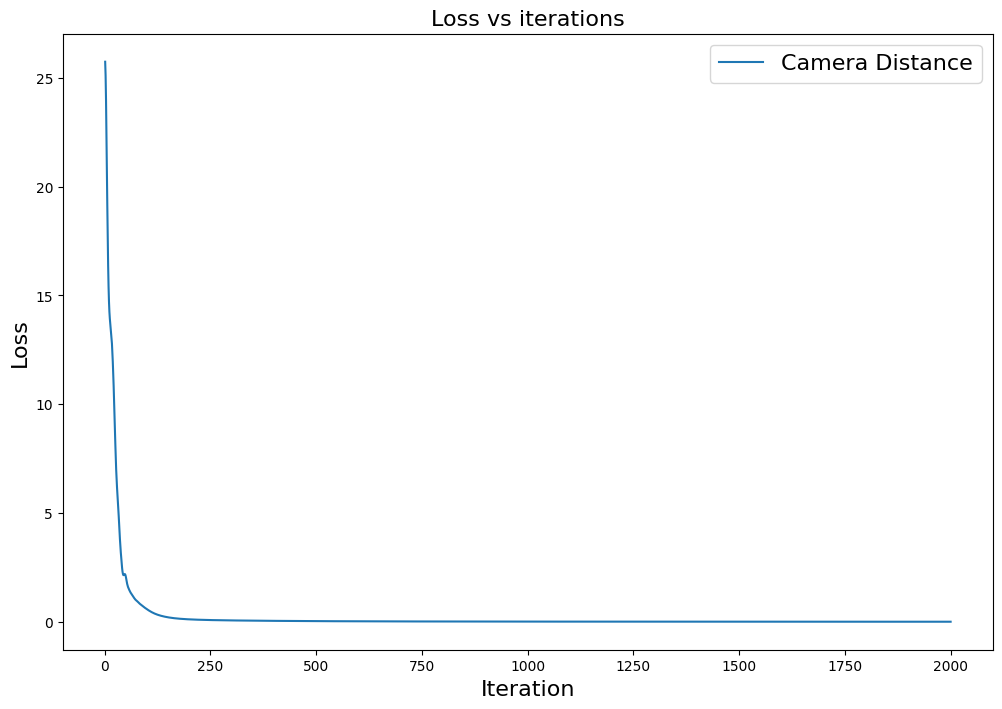

In [17]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
ax.plot([i for i in range(1, len(losses)+1)], losses, label="Camera Distance")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");


In [18]:
opt_images = render_scene(cow_mesh, cameras_absolute, device)

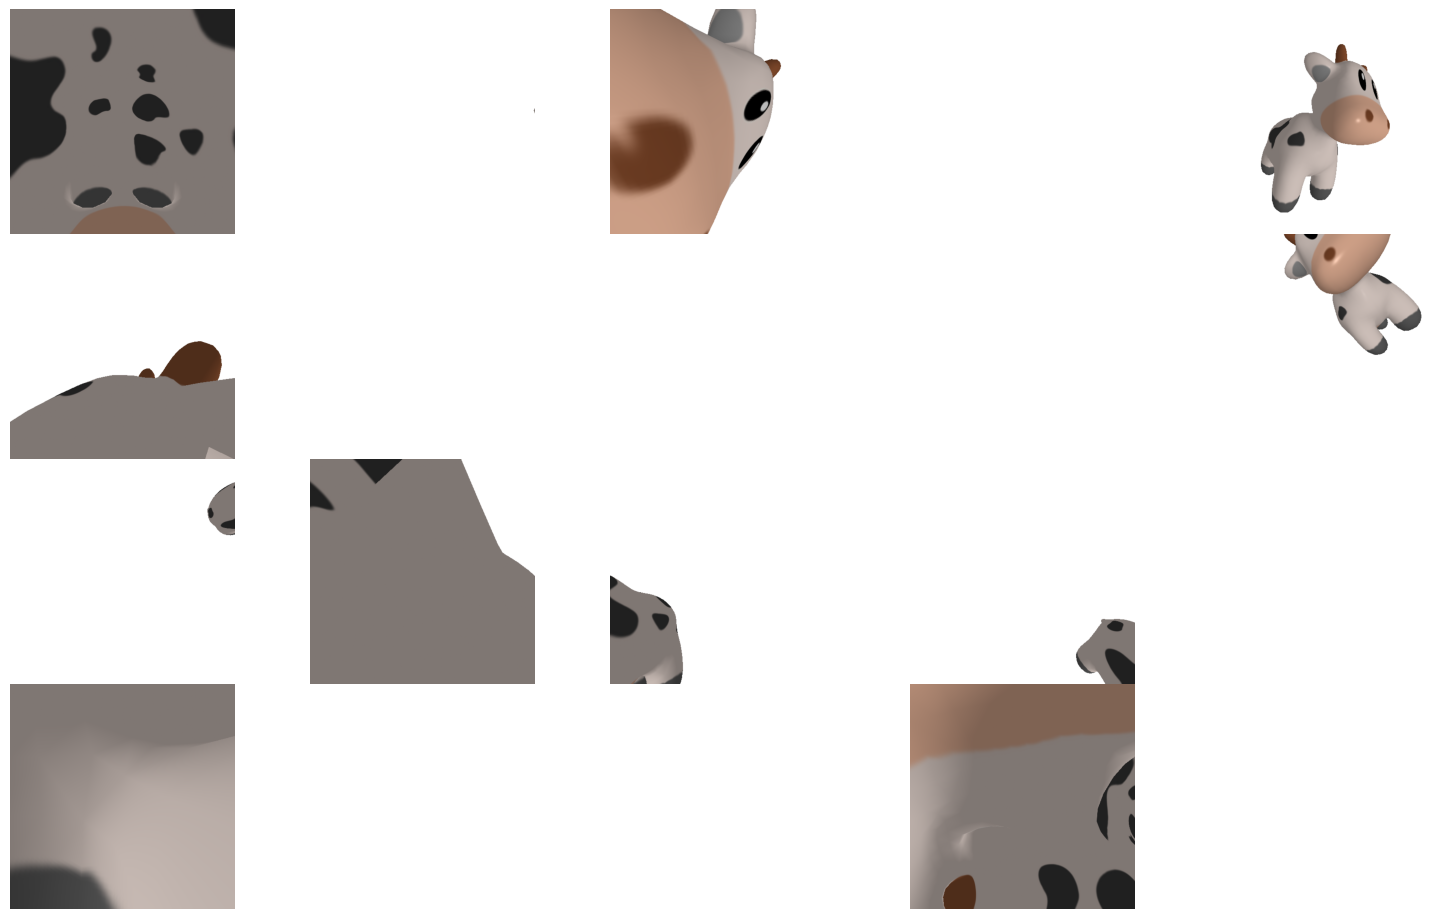

In [19]:
image_grid(opt_images.cpu().numpy(), 4, 5, rgb=True)

## A proposal for solving E.2

In [20]:
# Check: https://arxiv.org/abs/2006.14616
# @inproceedings{levinson20neurips,
#   title = {An Analysis of {SVD} for Deep Rotation Estimation},
#   author = {Jake Levinson, Carlos Esteves, Kefan Chen, Noah Snavely, Angjoo Kanazawa, Afshin Rostamizadeh, and Ameesh Makadia},
#   booktitle = {Advances in Neural Information Processing Systems 34},
#   year = {2020},
#   note = {To appear in}
# }
def symmetric_orthogonalization(x):
  """Maps 9D input vectors onto SO(3) via symmetric orthogonalization.

  x: should have size [batch_size, 9]

  Output has size [batch_size, 3, 3], where each inner 3x3 matrix is in SO(3).
  """
  m = x.view(-1, 3, 3)
  u, s, v = torch.svd(m)
  vt = torch.transpose(v, 1, 2)
  det = torch.det(torch.matmul(u, vt))
  det = det.view(-1, 1, 1)
  vt = torch.cat((vt[:, :2, :], vt[:, -1:, :] * det), 1)
  r = torch.matmul(u, vt)
  return r

In [21]:
def calc_camera_distance2(cam_1, cam_2):
    # rotation distance
    R_distance = ((cam_1.R - cam_2.R)**2).sum(1).mean()
    # translation distance
    T_distance = ((cam_1.T - cam_2.T)**2).sum(1).mean()
    # the final distance is the sum
    return R_distance + T_distance

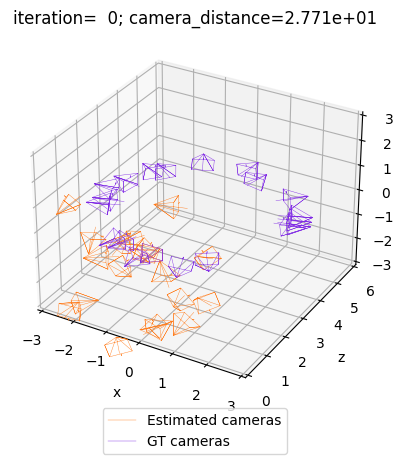

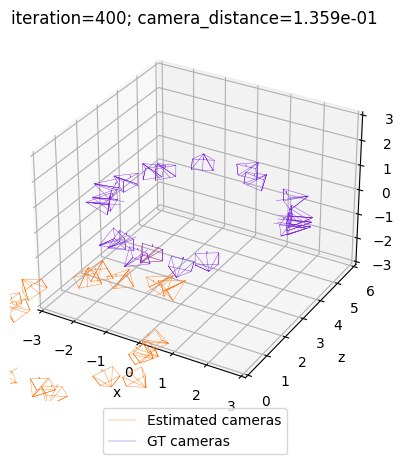

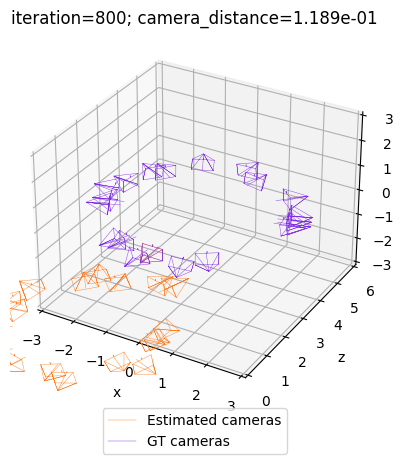

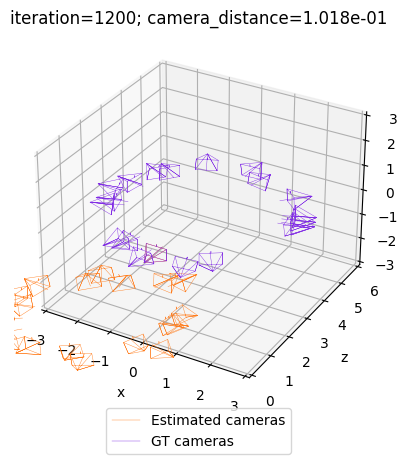

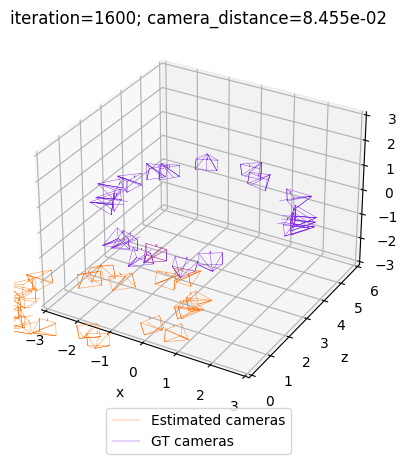

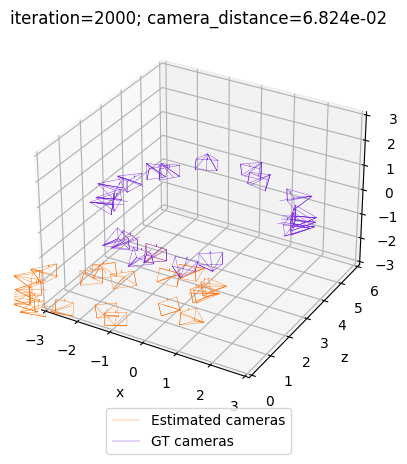

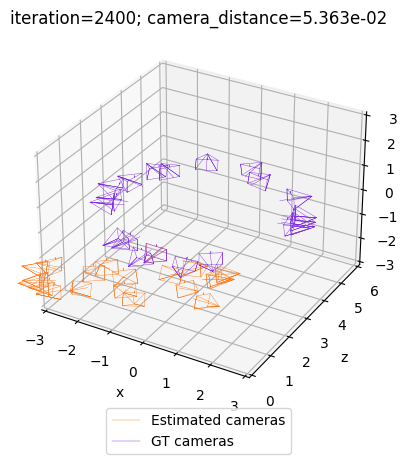

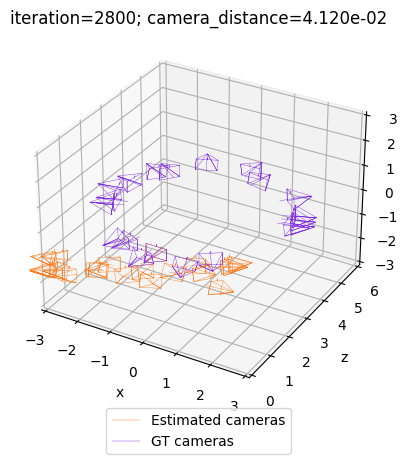

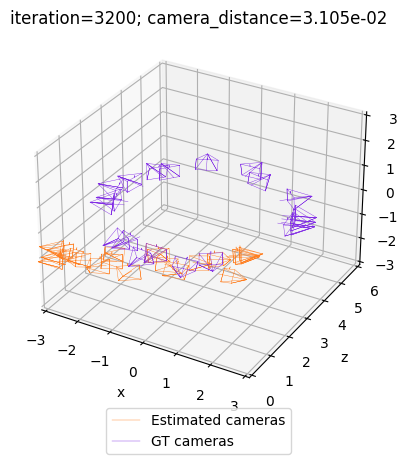

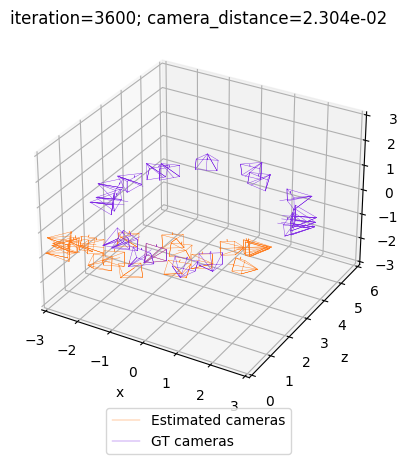

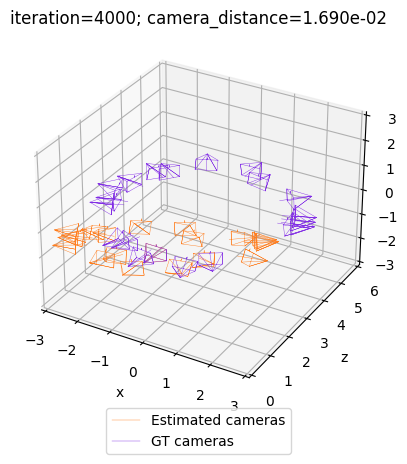

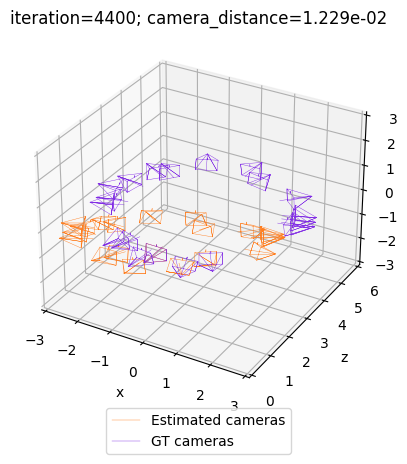

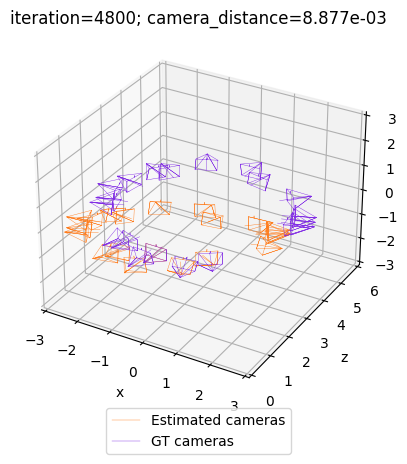

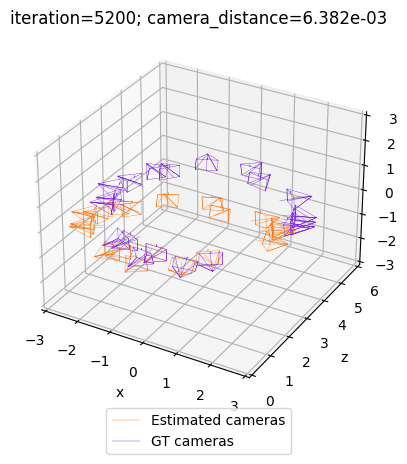

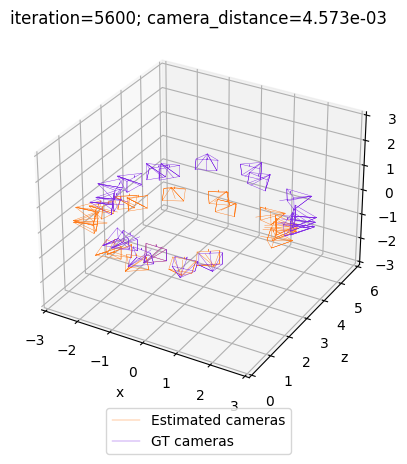

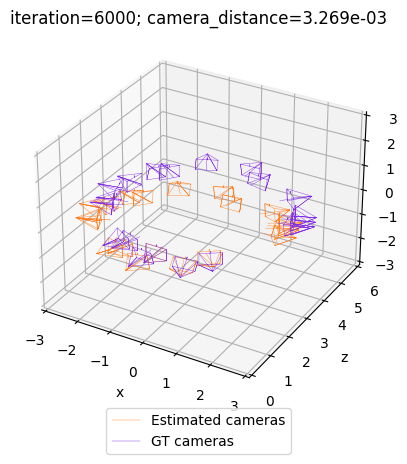

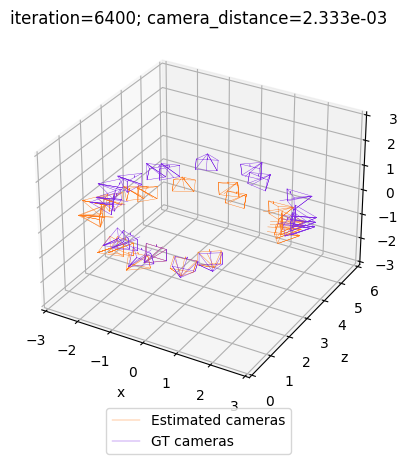

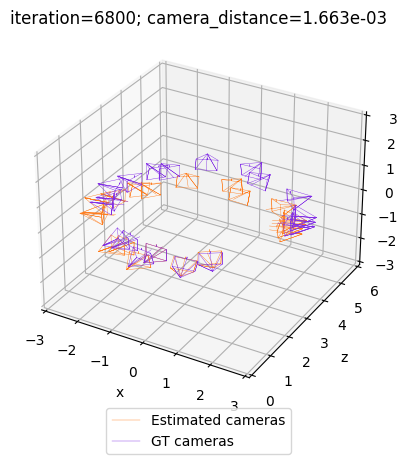

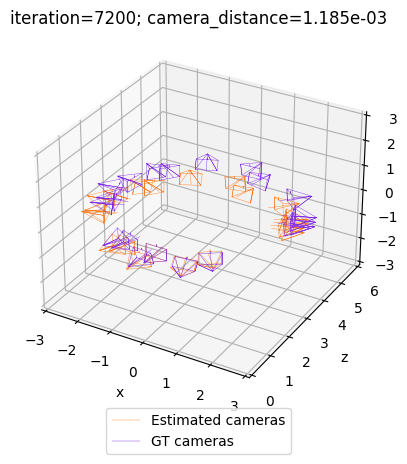

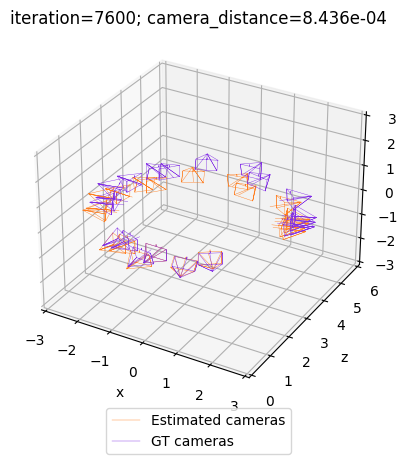

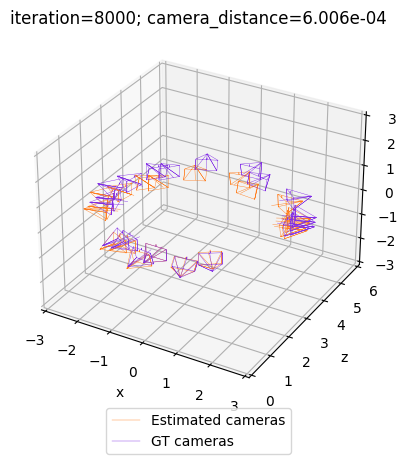

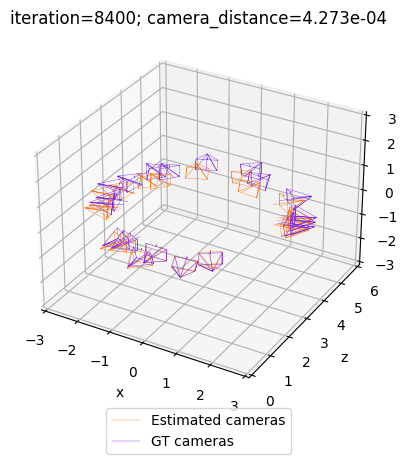

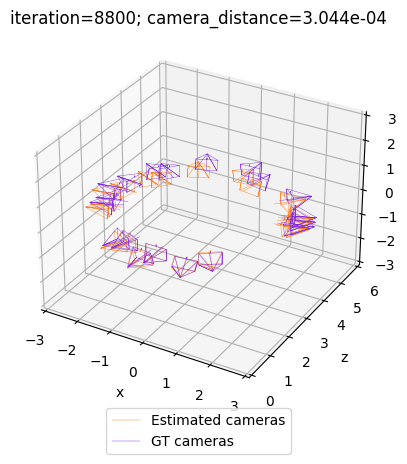

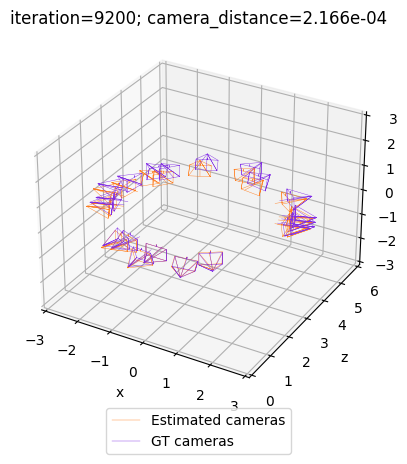

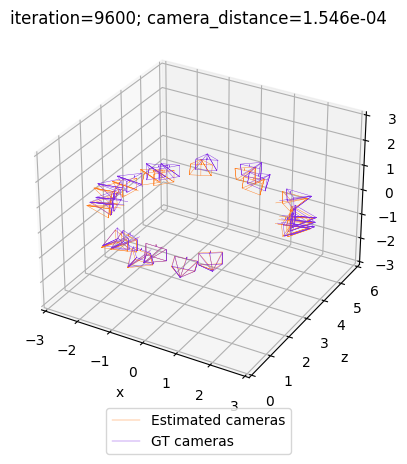

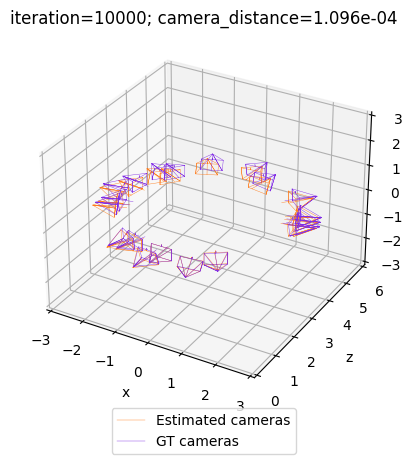

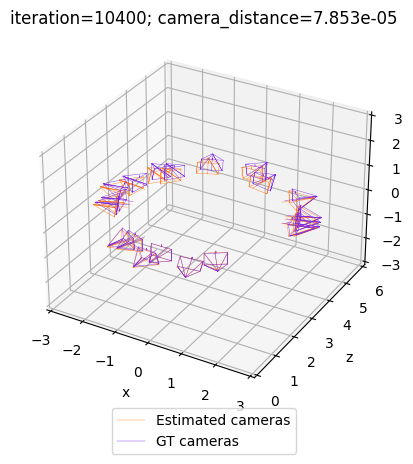

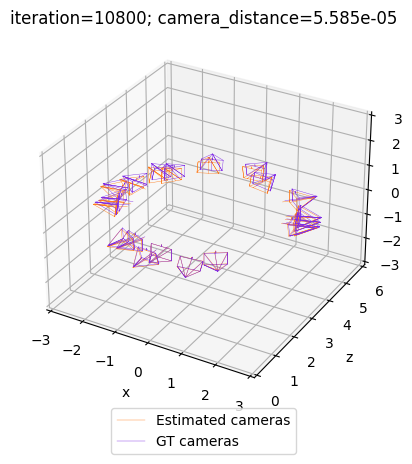

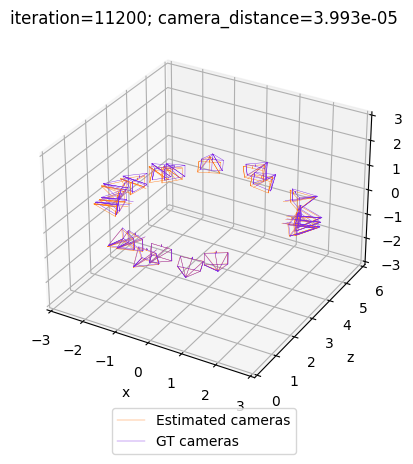

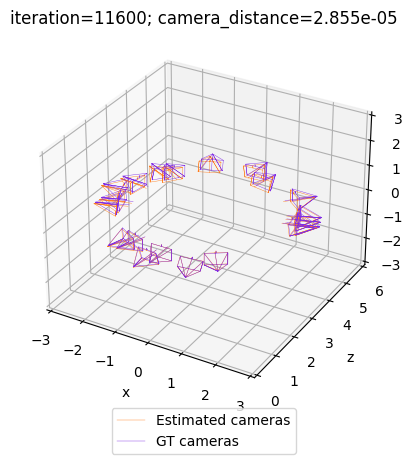

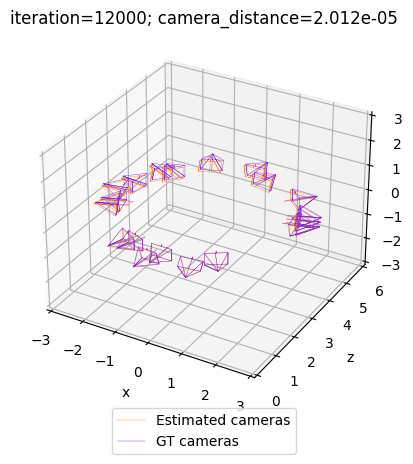

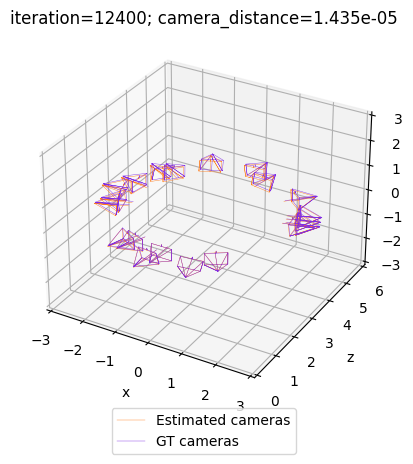

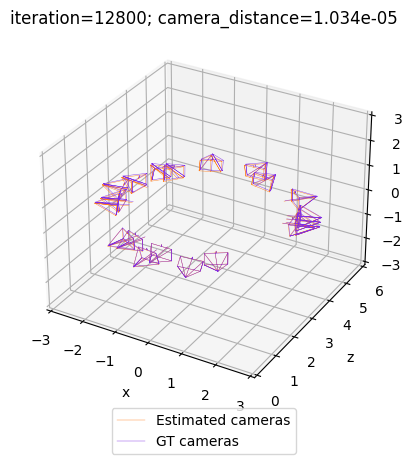

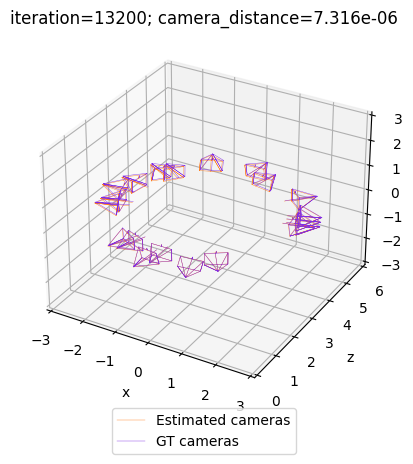

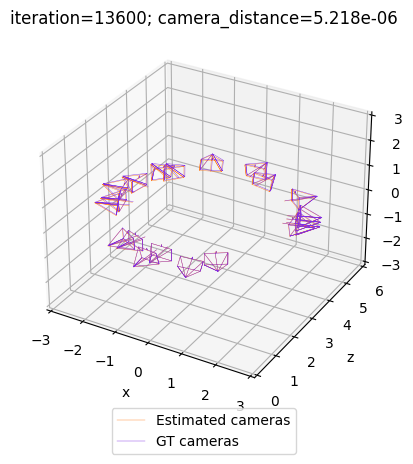

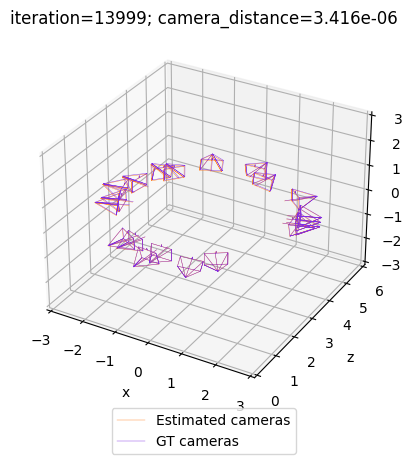

Optimization finished.


In [22]:
# initialize the absolute rotations/translations with random entries
vec_R_absolute_init = torch.randn(N-1, 9, dtype=torch.float32, device=device)
T_absolute_init = torch.randn(N-1, 3, dtype=torch.float32, device=device)

# furthermore, we know that the first camera is a trivial one
# (check exercise 1.1 above)
# vec_R_absolute_init[0, :] = torch.tensor([1.,0.,0.,0.,1.,0.,0.,0.,1.])
# T_absolute_init[0, :] = 0.

# instantiate a copy of the initialization of R / T
vec_R_absolute = vec_R_absolute_init.clone().detach()
vec_R_absolute.requires_grad = True
T_absolute = T_absolute_init.clone().detach()
T_absolute.requires_grad = True

# the mask the specifies which cameras are going to be optimized
#     (since we know the first camera is already correct,
#      we only optimize over the 2nd-to-last cameras)
# camera_mask = torch.ones(N, 1, dtype=torch.float32, device=device)
# camera_mask[0] = 0.

# !! init the optimizer
R0 = torch.tensor([1.,0.,0.,0.,1.,0.,0.,0.,1.]).unsqueeze(0).to(device)
T0 = torch.tensor([0., 0, 0]).unsqueeze(0).to(device)
optimizer = torch.optim.SGD([vec_R_absolute, T_absolute], lr=.1, momentum=0.9)

lossesSVD = []
# run the optimization
n_iter = 14000  # fix the number of iterations
for it in range(n_iter):
    # re-init the optimizer gradients
    optimizer.zero_grad()

    # compute the absolute camera rotations projecting on SO3 using SVD

    # !! R_absolute = so3_exponential_map(log_R_absolute * camera_mask)
    R_test = torch.concatenate([R0, vec_R_absolute])
    R_absolute = symmetric_orthogonalization(R_test)

    # get the current absolute cameras
    cameras_absolute = PerspectiveCameras(
        R = R_absolute,
        T = torch.concatenate([T0, T_absolute]), #T_absolute * camera_mask,
        device = device,
    )

    # compute the relative cameras as a compositon of the absolute cameras
    cameras_relative_composed = \
        get_relative_camera(cameras_absolute, relative_edges)

    # compare the composed cameras with the ground truth relative cameras
    # camera_distance corresponds to $d$ from the description
    camera_distance = \
        calc_camera_distance(cameras_relative_composed, cameras_relative)

    # 3.2 SAVE LOSS VALUE TO PLOT LATER
    lossesSVD.append(camera_distance.item())

    # our loss function is the camera_distance
    camera_distance.backward()

    # apply the gradients
    optimizer.step()

    # plot and print status message
    if it % 400==0 or it==n_iter-1:
        status = 'iteration=%3d; camera_distance=%1.3e' % (it, camera_distance)
        plot_camera_scene(cameras_absolute, cameras_absolute_gt, status)

print('Optimization finished.')


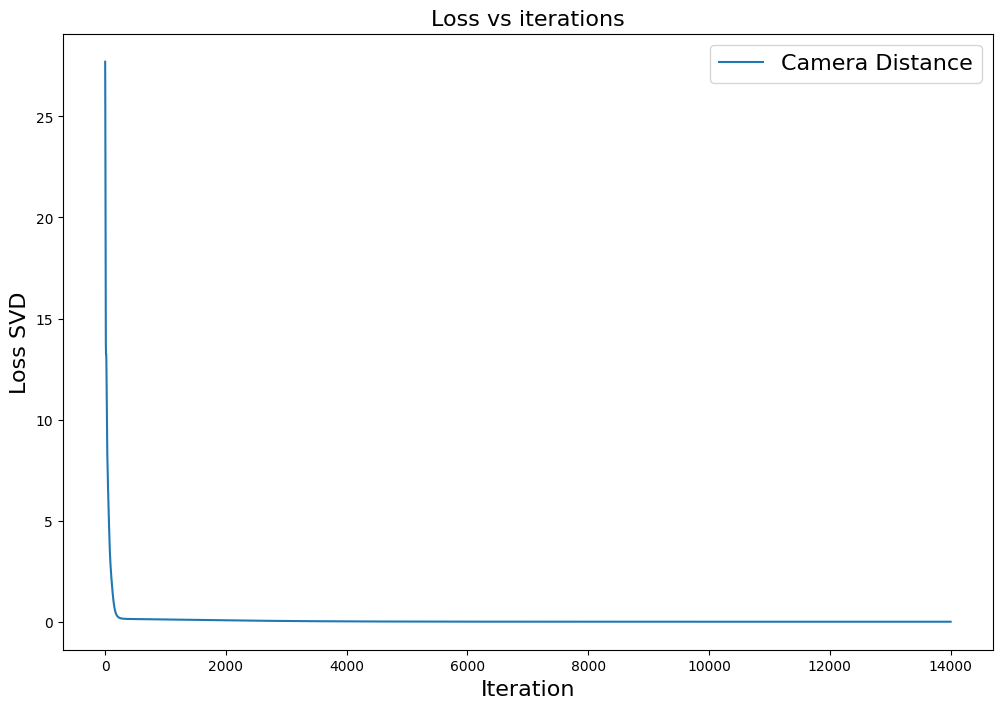

In [23]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
ax.plot([i for i in range(1, len(lossesSVD)+1)], lossesSVD, label="Camera Distance")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss SVD", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

In [24]:
svd_images = render_scene(cow_mesh, cameras_absolute, device)

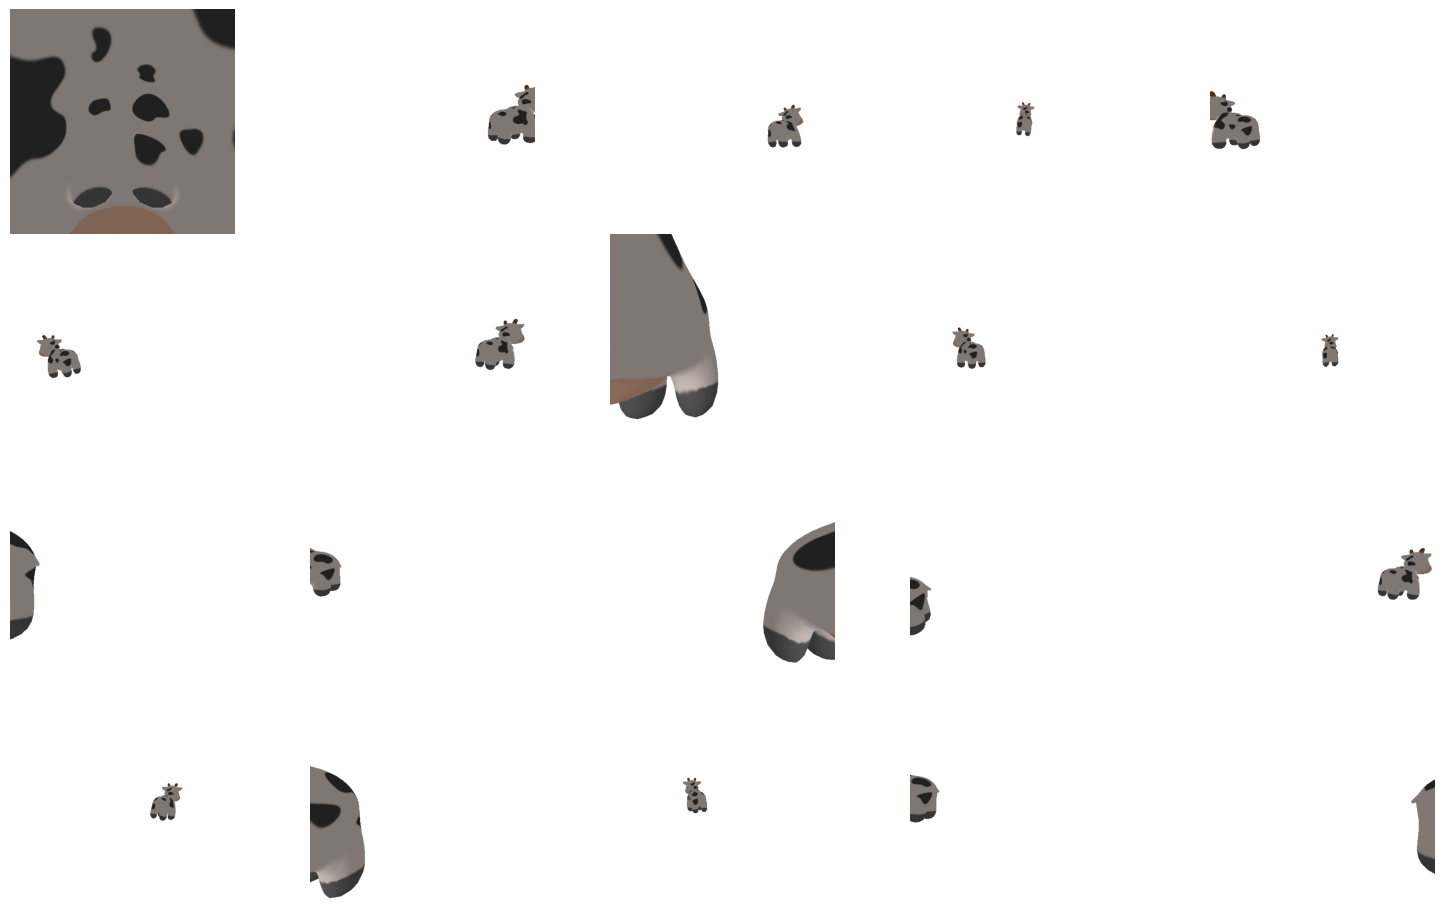

In [25]:
image_grid(svd_images.cpu().numpy(), 4, 5, rgb=True)

In [26]:
from pytorch3d.transforms import Transform3d, Rotate, Translate
from pytorch3d.structures import Meshes

In [27]:
centroid = torch.mean(cameras_absolute_gt.T, 0)
translation = Translate(centroid[0], centroid[1], centroid[2], device=device)
cow_verts = translation.transform_points(cow_mesh.verts_packed())
new_mesh = Meshes([cow_verts],
                  cow_mesh.faces_list(),
                  textures=cow_mesh.textures).to(device)

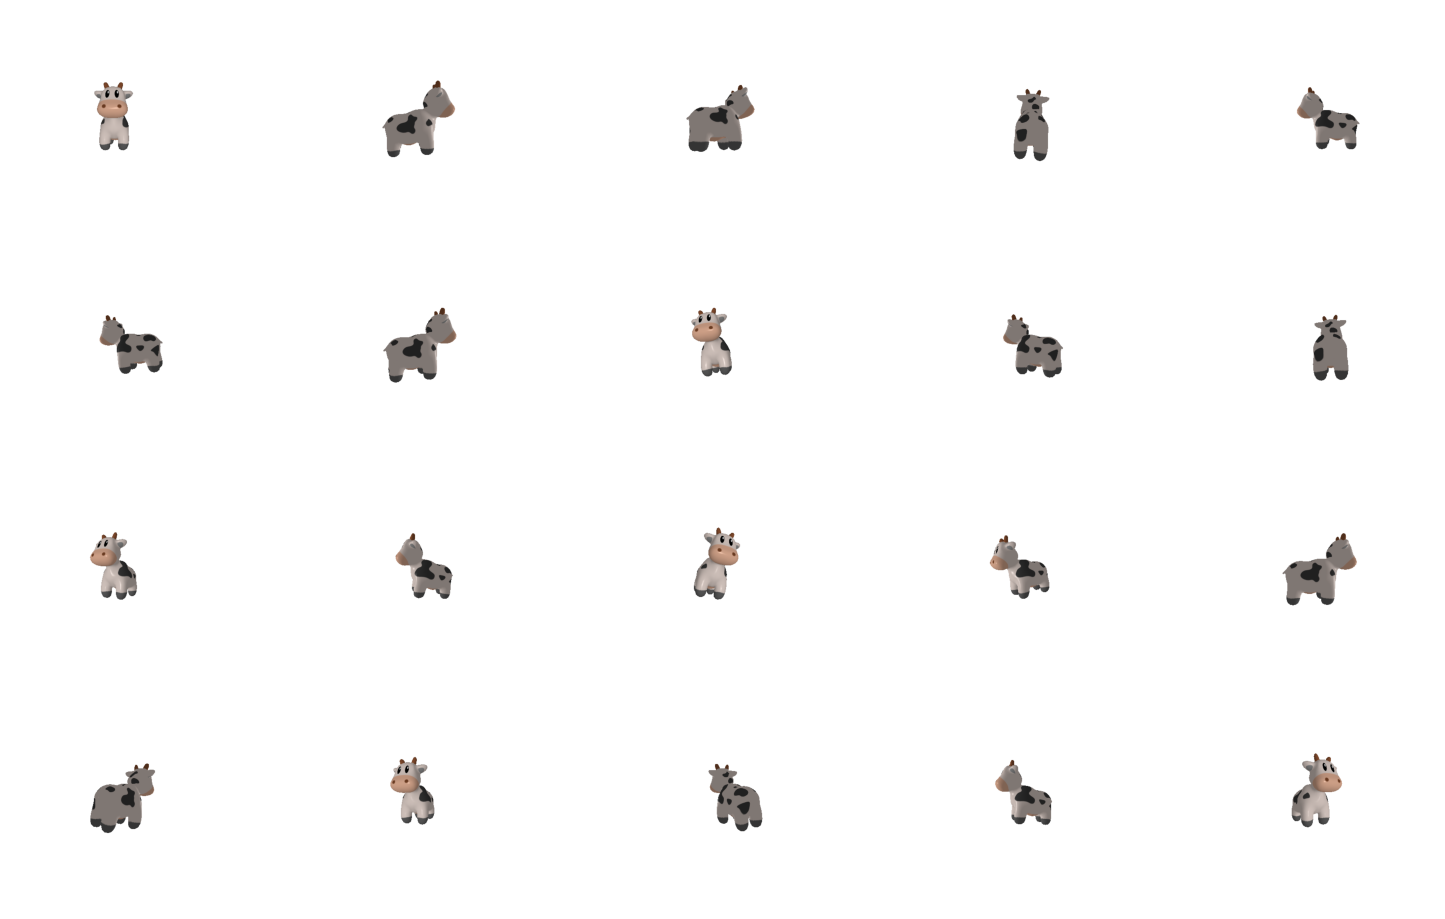

In [28]:
svd_images = render_scene(new_mesh, cameras_absolute, device)
image_grid(svd_images.cpu().numpy(), 4, 5, rgb=True)

In [29]:
cameras_absolute_gt.R[0]

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

In [30]:
cameras_absolute.R[0]

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0', grad_fn=<SelectBackward0>)